# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

# functions

## Gaussian

In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-x**2/2/s**2))/s/np.sqrt(2*np.pi)

## Feedback and  Feedforward one layer-1D

![C-H-B fig1.png](Markdown%20Figure/C-H-B%20fig1.png)

In [3]:
def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    plt.plot(KC)
    plt.plot(KH)
    plt.plot(KB)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+para_dict['k']*(s-para_dict['phi']*zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i-1,:]))*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

In [4]:
def Bipolar(yts, zts, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(yts.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    plt.plot(KC)
    plt.plot(KH)
    plt.plot(KB)
    
    wts = np.zeros_like(yts)#horizontal
    rpeak2 = np.zeros(np.shape(yts)[0])
    rinvertpeak2 = np.zeros(np.shape(yts)[0])
    

    for i in range(np.shape(yts)[0]):
        ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
        wts[i,:] = (wts[i-1,:]+dwj)
        maxpos2 = np.argmax(wts[i,:])
        rpeak2[i]= maxpos2*dx
        maxipos2 = np.argmin(wts[i,:])
        rinvertpeak2[i]= maxipos2*dx
    

    return wts, rpeak2, rinvertpeak2

## Equal State 

In [5]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

## PIfunc

In [6]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

## Spike_Time_Generator

In [7]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

## activation function

In [8]:
# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# Main

## Set parameters

### CKC's parameters

In [9]:
dt = 0.01

sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*0.2# RF size of cone cell
dx = sigma_dict['H']/50. #1/sstep
 
#sigma_dict['tau_y'] = 0.01                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#Width setting
Dynamical_range = 6*sigma_dict['H']/dx #188-16 pixels
hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
xlen = 10*sigma_dict['H'] #spatial extend of simulation
tempx = np.arange(0,xlen,dx)

para_dict = {}
para_dict['alpha'] = 40.
para_dict['beta'] = 2.
para_dict['k'] = 40.
para_dict['phi'] = 5.
para_dict['g'] = 2.

para_dict['gramma'] = 100.
para_dict['p'] = 100.
para_dict['psy'] = 0.2

sigma_dict['B'] = sigma_dict['H']*0.5

### Leo's parameters

In [10]:
# dt = 0.001

# NGD_sigma_dict = dict()
# NGD_sigma_dict['H'] = 1
# NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.75# RF size of cone cell
# dx = NGD_sigma_dict['H']/40
 
# #sigma_dict['tau_y'] = 0.01                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# #Width setting
# Dynamical_range = 6*NGD_sigma_dict['H']/dx #188-16 pixels
# hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
# xlen = 50*NGD_sigma_dict['H'] #spatial extend of simulation
# tempx = np.arange(0,xlen,dx)

# NGD_para_dict = {}
# NGD_para_dict['alpha'] = 40.
# NGD_para_dict['beta'] = 2.
# NGD_para_dict['k'] = 50.
# NGD_para_dict['phi'] = 20.
# NGD_para_dict['g'] = 2.


# FBFF_sigma_dict = NGD_sigma_dict.copy()
# FBFF_para_dict = NGD_para_dict.copy()
# FBFF_para_dict['gramma'] = 40.
# FBFF_para_dict['p'] = 40.
# FBFF_para_dict['psy'] = 1.2

# FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.5


# FFFB_para_dict, FFFB_sigma_dict = {}, {}
# FFFB_para_dict['alpha2'] = NGD_para_dict['alpha']*2
# FFFB_para_dict['beta2'] = NGD_para_dict['beta']*2
# FFFB_para_dict['k2'] = NGD_para_dict['k']*2
# FFFB_para_dict['phi'] = 1
# FFFB_para_dict['psy'] = FBFF_para_dict['psy']
# FFFB_para_dict['g2'] = NGD_para_dict['g']*2

# FFFB_para_dict['alpha1'] = NGD_para_dict['alpha']
# FFFB_para_dict['beta1'] = NGD_para_dict['beta']
# FFFB_para_dict['k1'] = NGD_para_dict['k']
# FFFB_para_dict['g1'] = NGD_para_dict['g']

# FFFB_sigma_dict['H'] =  NGD_sigma_dict['H']
# FFFB_sigma_dict['B'] = NGD_sigma_dict['C']
# FFFB_sigma_dict['A'] = FFFB_sigma_dict['B']*2.

## Smooth Motion

In [11]:
nstep = int(1.6/dt)
moving_bar = np.zeros([nstep, int(xlen/dx)])
pos = int(hw/dx*4)
v = 2.5*hw/dx #sstep/s
SM_speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v*dt
    moving_bar[i,max(int(round(pos-hw/dx)), 0):min(int(round(pos+hw/dx)), int(xlen/dx))] = 1
    SM_speak[i] = pos*dx

### Feedback and  Feedforward one layer-1D

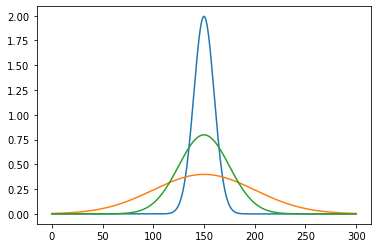

In [12]:
SbS_y, zts, yts, rpeak1, rpeak2, rinvertpeak2 = FB_FF_1l_1D(moving_bar, sigma_dict, para_dict, dx, dt)

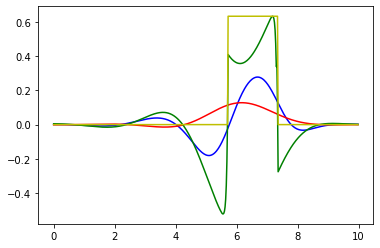

In [13]:
#####PLot numerical solution########
plt.plot(tempx,SbS_y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution
plt.plot(tempx,yts.T[:,-1],'g')#numerical solution
plt.plot(tempx,moving_bar.T[:,-1]*max(yts.T[:,-1]),'y')
# plt.xlim([25, 30])

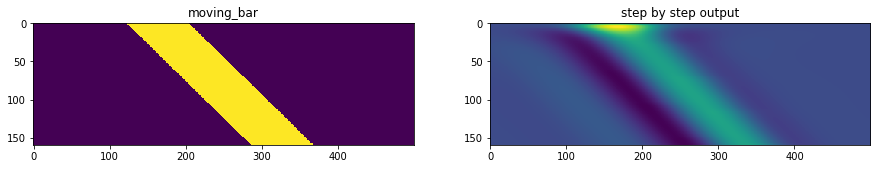

In [14]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_y)
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

Text(0.5, 1.0, 'prediction')

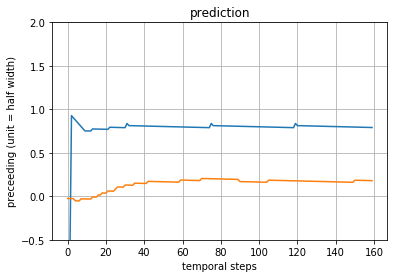

In [15]:
plt.plot(((rpeak1-SM_speak)/hw))
plt.plot(((rpeak2-SM_speak)/hw))
# plt.plot(((rinvertpeak2-SM_speak)/hw)[:])
# plt.xlim([100,nstep])
plt.ylim([-0.5,2])
plt.grid()
plt.ylabel('preceeding (unit = half width)')
plt.xlabel('temporal steps')
plt.title('prediction')

## \Psy vs. prediction

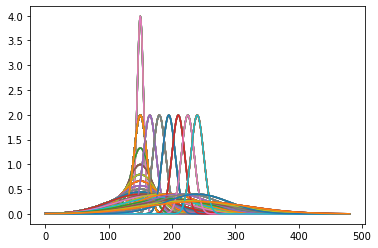

In [16]:
psy_list = np.arange(0.1,1.0,0.1)
BoverH_list = np.arange(0.1,1.7,0.1)
tabel1 = np.zeros((len(psy_list), len(BoverH_list)))
tabel2 = np.zeros((len(psy_list), len(BoverH_list)))
tabel3 = np.zeros((len(psy_list), len(BoverH_list)))
for i in range(len(psy_list)):
    for j in range(len(BoverH_list)):
        para_dict['psy'] = psy_list[i]
        sigma_dict['B'] = sigma_dict['H']*BoverH_list[j]
        wts, _, _,rpeak1, rpeak2, rinvertpeak2 = FB_FF_1l_1D(moving_bar, sigma_dict, para_dict, dx, dt)
        tabel1[i,j]=(max(wts.T[:,-1]))
        tabel2[i,j]=((rpeak2-SM_speak)/hw)[-1]
        tabel3[i,j]=((rinvertpeak2-SM_speak)/hw)[-1]

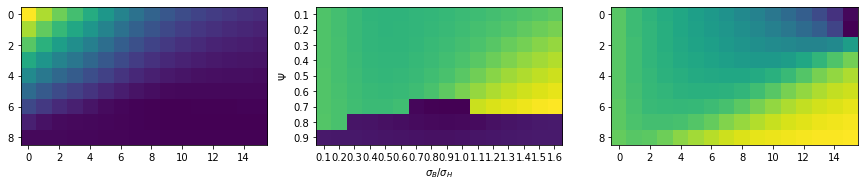

In [17]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3)
ax2.imshow(tabel1)
ax3.imshow(tabel2)
ax4.imshow(tabel3)
# ax3.colorbar()
ax3.set_yticks(range(len(psy_list)))
ax3.set_yticklabels(np.round(psy_list,2))
ax3.set_xticks(range(len(BoverH_list)))
ax3.set_xticklabels(np.round(BoverH_list,2))
ax3.set_ylabel(r'$\Psi$')
ax3.set_xlabel(r'$\sigma_B/\sigma_H$')
fig.set_size_inches(15,5)

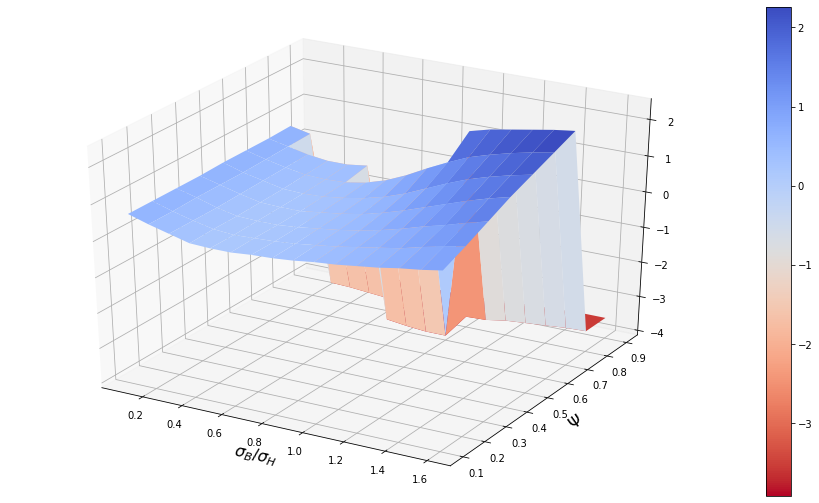

In [18]:
fig = plt.figure()
axis = fig.gca(projection='3d')
 
#產出X,Y,Z數據
x0 = psy_list
x1 = BoverH_list
X, Y = np.meshgrid(x1, x0)
 
#畫圖
# surface2 = axis.plot_wireframe(X, Y, tabel1, rstride=2, cstride=2, color = 'grey')
surface = axis.plot_surface(X, Y, tabel2, rstride=1, cstride=1, cmap='coolwarm_r')

fig.colorbar(surface, shrink=1.0, aspect=20)
 
# 設置圖表訊息
plt.ylabel(r'$\Psi$', fontsize=16)
plt.xlabel(r"$\sigma_B/\sigma_H$", fontsize=16)
 
fig.set_size_inches(16,9)

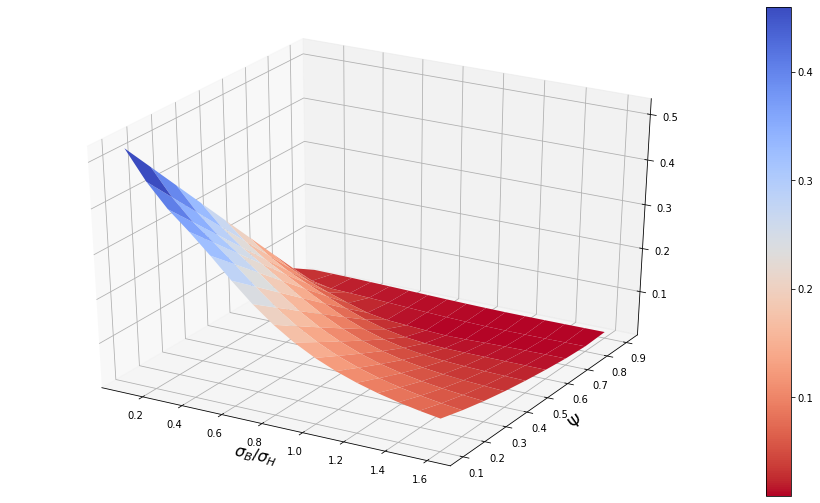

In [19]:
fig = plt.figure()
axis = fig.gca(projection='3d')
 
#產出X,Y,Z數據
x0 = psy_list
x1 = BoverH_list
X, Y = np.meshgrid(x1, x0)
 
#畫圖
# surface2 = axis.plot_wireframe(X, Y, tabel1, rstride=2, cstride=2, color = 'grey')
surface = axis.plot_surface(X, Y, tabel1, rstride=1, cstride=1, cmap='coolwarm_r')

fig.colorbar(surface, shrink=1.0, aspect=20)
 
# 設置圖表訊息
plt.ylabel(r'$\Psi$', fontsize=16)
plt.xlabel(r"$\sigma_B/\sigma_H$", fontsize=16)
 
fig.set_size_inches(16,9)

## LPOU-1D

In [20]:
#main
Tot=300
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [21]:
LPOU_bar = np.zeros([len(T), int(xlen/dx)])
speak = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*Dynamical_range
speak = speak-np.mean(speak)+int(xlen/dx/2)
for i in range(len(T)):
    pos = speak[i]
    min_pos = max(int(pos-hw/dx), 0)
    max_pos = min(int(pos+hw/dx), int(xlen/dx))
    LPOU_bar[i,min_pos:max_pos] = 1

In [22]:
# LPOU_bar = np.abs(LPOU_bar-1)

In [23]:
# LPOU_bar = np.fliplr(LPOU_bar)

In [24]:
#assign states
x = speak.copy()*dt
x = x.astype(float)
# x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=5, order=1, mode='reflect') / dt
# v = findiff.FinDiff(0, dt, acc=4)(x)
xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)

### Feedback and  Feedforward one layer-1D

In [25]:
XOon = 1

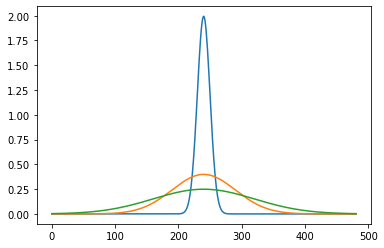

In [26]:
wts, zts, yts ,_,_,_ = FB_FF_1l_1D(LPOU_bar, sigma_dict, para_dict, dx, dt)

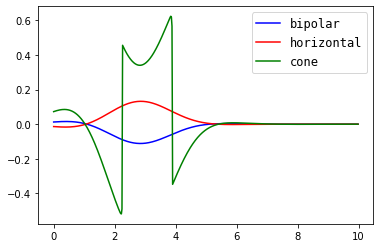

In [27]:
#####PLot numerical solution########
plt.plot(tempx,wts.T[:,-1],'b') #numerical solution
plt.plot(tempx,zts.T[:,-1],'r') #numerical solution
plt.plot(tempx,yts.T[:,-1],'g') #numerical solution
plt.legend( ('bipolar', 'horizontal', 'cone'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.xlim([15, 20])

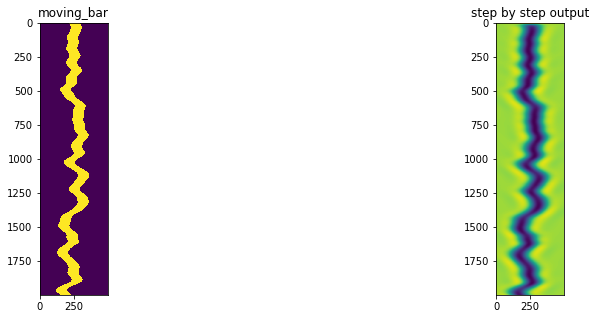

In [28]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
ax2.imshow(LPOU_bar[:2000])
ax2.set_title('moving_bar')
ax3.imshow(wts[:2000])
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

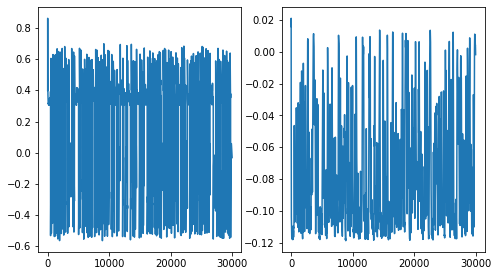

In [29]:
Sindex = int(xlen/dx/2)
ww = np.zeros(wts.shape[0])
yy = np.zeros(yts.shape[0])
for i in range( wts.shape[0]):
    ww[i] = wts[i][Sindex]
    yy[i] = yts[i][Sindex]
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2) 
ax3.plot(ww)
ax2.plot(yy)
fig.set_size_inches(8,4.5)

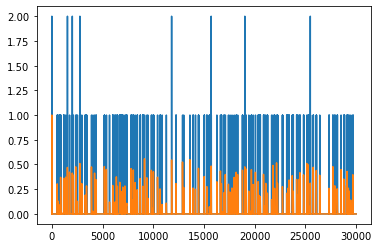

In [30]:
cr = NL(-np.mean(yy)+yy, 1*np.std(yy))
ratio = sum(cr)/Tot/3
cFakeSpike = Spike_Time_Generater(cr/ratio, dt, 10)
crstate,_  = np.histogram(cFakeSpike, np.append(0,T))
plt.plot(crstate)
plt.plot(cr/max(cr))

In [31]:
window = [-1,1] # second
timeshift, cInformation = PIfunc(crstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

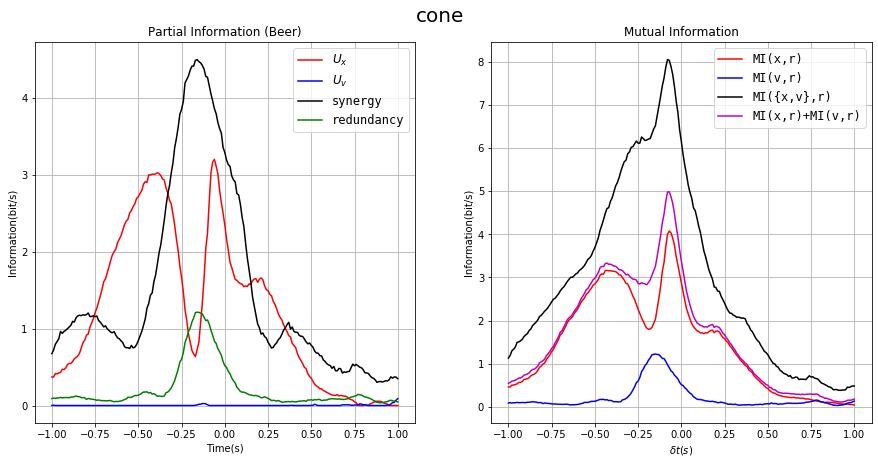

In [32]:
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2) 
fig.suptitle('cone', y=0.95, fontsize=20)
ax2.plot(timeshift,cInformation[('Beer','UIx')], 'r-')
ax2.plot(timeshift,cInformation[('Beer','UIv')], 'b-')
ax2.plot(timeshift,cInformation[('Beer','Syn')], 'k-')
ax2.plot(timeshift,cInformation[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,cInformation[('Beer','UIx')]+cInformation[('Beer','Red')], 'r-')
ax3.plot(timeshift,cInformation[('Beer','UIv')]+cInformation[('Beer','Red')], 'b-')
ax3.plot(timeshift,cInformation[('Beer','Syn')]+cInformation[('Beer','Red')]+cInformation[('Beer','UIv')]+cInformation[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*cInformation[('Beer','Red')]+cInformation[('Beer','UIv')]+cInformation[('Beer','UIx')], 'm-')
ax3.set_title('Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

fig.set_size_inches(15, 7)

In [33]:
cMIpeaktime = np.round(timeshift[np.argmax(cInformation[('Beer','UIx')]+cInformation[('Beer','Red')])],3)

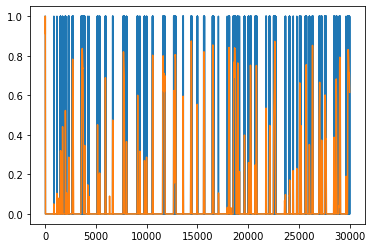

In [34]:
if XOon == 1:
    r = NL(-np.mean(ww)+ww, 1*np.std(ww))
else:
    r = NL(np.mean(ww)-ww, 1*np.std(ww))
ratio = sum(r)/Tot/3
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate,_  = np.histogram(FakeSpike, np.append(0,T))
plt.plot(rstate)
plt.plot(r/max(r))

In [35]:
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

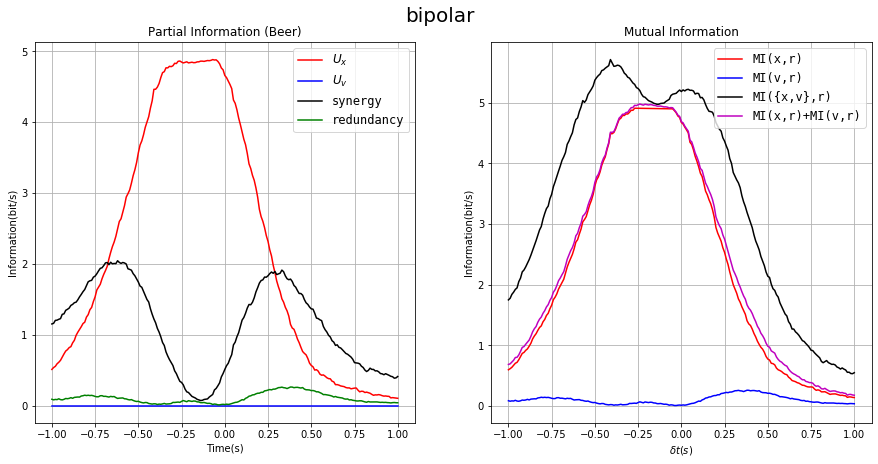

In [36]:
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('bipolar', y=0.95, fontsize=20)
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','Syn')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','UIx')], 'm-')
ax3.set_title('Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

fig.set_size_inches(15, 7)

### \Psi vs. MI peak time 

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered i

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in multiply


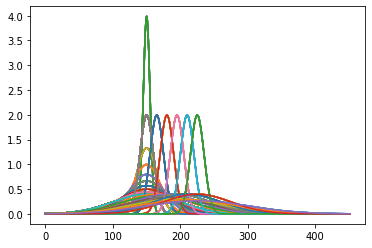

In [37]:
psy_list = np.arange(0.1,1.0,0.1)
BoverH_list = np.arange(0.1,1.6,0.1)
MItabelt = np.zeros((len(psy_list), len(BoverH_list)))
MItabelh = np.zeros((len(psy_list), len(BoverH_list)))
for i in range(len(psy_list)):
    for j in range(len(BoverH_list)):
        para_dict['psy'] = psy_list[i]
        sigma_dict['B'] = sigma_dict['H']*BoverH_list[j]
        

        wts,_,_ = Bipolar(yts, zts, sigma_dict, para_dict, dx, dt)
        for k in range( wts.shape[0]):
            ww[k] = wts[k][Sindex]
            
        if XOon == 1:
            r = NL(-np.mean(ww)+ww, 1*np.std(ww))
        else:
            r = NL(np.mean(ww)-ww, 1*np.std(ww))
        ratio = sum(r)/Tot/3
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate,_  = np.histogram(FakeSpike, np.append(0,T))
        window = [-1,1] # second
        timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
        MItabelt[i,j] = np.round(timeshift[np.argmax(Information[('Beer','UIx')]+Information[('Beer','Red')])],3)
        MItabelh[i,j] = np.round(max(Information[('Beer','UIx')]+Information[('Beer','Red')]),3)

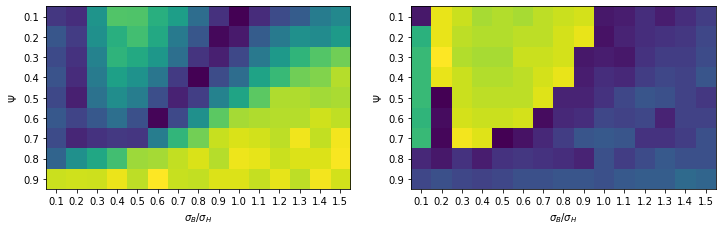

In [38]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
ax2.imshow(MItabelh)
ax3.imshow(MItabelt)
ax3.set_yticks(range(len(psy_list)))
ax3.set_yticklabels(np.round(psy_list,2))
ax3.set_xticks(range(len(BoverH_list)))
ax3.set_xticklabels(np.round(BoverH_list,2))
ax3.set_ylabel(r'$\Psi$')
ax3.set_xlabel(r'$\sigma_B/\sigma_H$')
ax2.set_yticks(range(len(psy_list)))
ax2.set_yticklabels(np.round(psy_list,2))
ax2.set_xticks(range(len(BoverH_list)))
ax2.set_xticklabels(np.round(BoverH_list,2))
ax2.set_ylabel(r'$\Psi$')
ax2.set_xlabel(r'$\sigma_B/\sigma_H$')
fig.set_size_inches(16,9)
fig.set_size_inches(12, 9*4./3.)

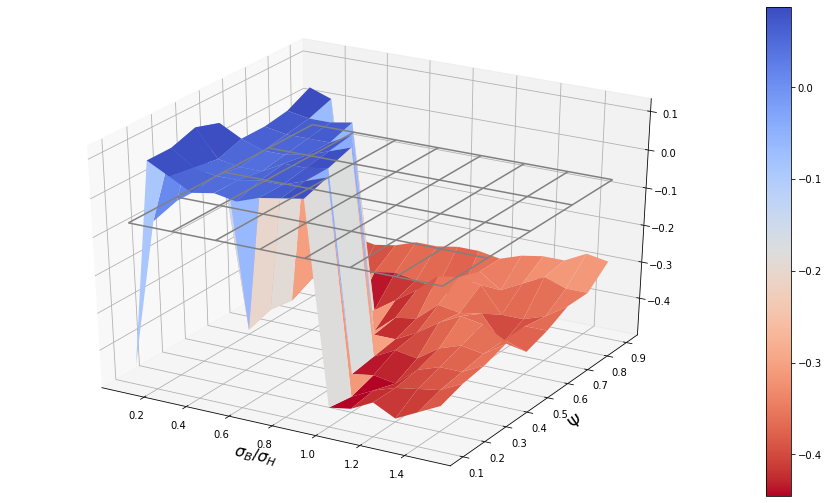

In [39]:
fig = plt.figure()
axis = fig.gca(projection='3d')
 
#產出X,Y,Z數據
x0 = psy_list
x1 = BoverH_list
X, Y = np.meshgrid(x1, x0)
cMIpeaktime_table = np.ones_like(MItabelt)*cMIpeaktime
 
#畫圖
surface = axis.plot_surface(X, Y, MItabelt, rstride=1, cstride=1, cmap='coolwarm_r')
surface2 = axis.plot_wireframe(X, Y, cMIpeaktime_table, rstride=2, cstride=2, color = 'grey')
fig.colorbar(surface, shrink=1.0, aspect=20)
 
# 設置圖表訊息
plt.ylabel(r'$\Psi$', fontsize=16)
plt.xlabel(r"$\sigma_B/\sigma_H$", fontsize=16)
 
fig.set_size_inches(16,9)

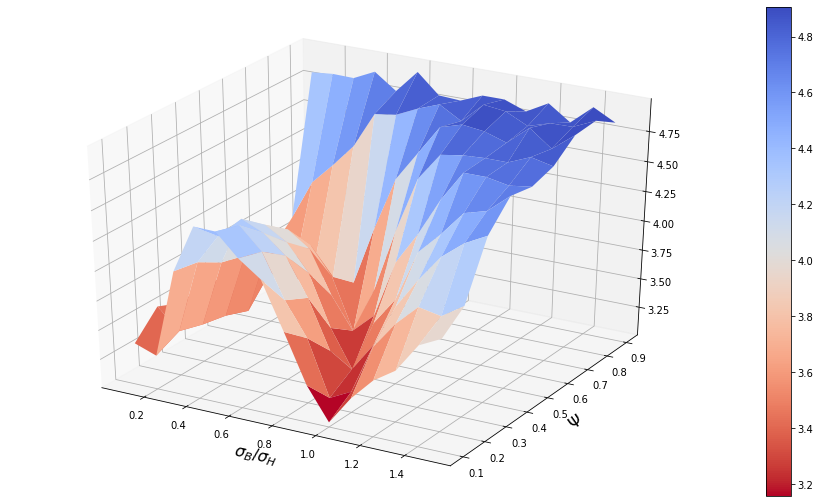

In [40]:
fig = plt.figure()
axis = fig.gca(projection='3d')
 
#產出X,Y,Z數據
x0 = psy_list
x1 = BoverH_list
X, Y = np.meshgrid(x1, x0)
 
#畫圖
surface = axis.plot_surface(X, Y, MItabelh, rstride=1, cstride=1, cmap='coolwarm_r')
fig.colorbar(surface, shrink=1.0, aspect=20)
 
# 設置圖表訊息
plt.ylabel(r'$\Psi$', fontsize=16)
plt.xlabel(r"$\sigma_B/\sigma_H$", fontsize=16)
 
fig.set_size_inches(16,9)